# <center>**[ 나라별 유튜브 인기 카테고리 분석 ]**</center>
<img src="http://img.etnews.com/photonews/1708/988982_20170830094220_820_0004.jpg" width="500" height="600">
  
    
      
        
        

## 1. 주제 선정 이유  
<img src = "https://file2.nocutnews.co.kr/newsroom/image/2018/05/17/20180517140852159718_6_710_473.jpg" width="500" height="600">  

와이즈앱이 2017년 11월에 발표한 결과 (안드로이드 사용자 2만 3천여명에 한함)에 따르면 10대가 가장 오래 사용하는 앱은 ‘유튜브’였습니다. 앱 사용시간이 무려 129백만시간으로, 10대들은 카카오톡과 페이스북 그리고 네이버앱의 사용 시간을 합친 것보다도 훨씬 더 많은 시간을 유튜브에 사용하고 있습니다. 그리고 2017년 3월 닐슨코리안클릭이 발표한 ‘세대별 모바일 애플리케이션 사용현황'(순 이용자수 기준)에서도 유튜브’의 강세를 느낄 수 있습니다. 10대(Generation Z)에서는 유튜브가 네이버를 앞지르고 2위로 올라섰으며, 카카오톡과의 격차 역시 세대 중에서 가장 적은 격차를 기록했습니다. 또한 ‘사용시간’ 측면에서는 모든 서비스들을 사뿐히 제치고 1등을 차지했습니다. 이러한 수요에 따라 최근 유튜버에 도전하는 이들이 많기 때문에, 조금 더 글로벌한 시장도 선점해볼 수 있게끔 나라별 유튜브 인기 카테고리를 분석해보고자 했습니다.


## 2. 가설 정의
문화의 차이로 인해서 나라별로 자주 스트리밍되는, 인기가 많은 카테고리가 서로 상이할 것이라는 가정 하에 분석을 진행합니다.

## 3. 인터넷을 통한 데이터 획득  

<img src="https://gs1.saro.me/FILE/83.png" width = "200" height="200" border="0" style="float:left;" />
<img src="https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99D417445C441D2E30" border="0" style="float:center;" />  

Youtube는 API key를 제공하고 있으며 기본적인 HTTP GET method는  https://www.googleapis.com/youtube/v3/ 이다. 개인적으로 발급 받은 Youtube API key와 requests module과 함께 얻은 나라별 유튜브 비디오 데이터들을 output디렉토리에 csv파일로 저장한다.

### a. 획득 데이터 - Youtube API key와 requests를 이용해 얻은 데이터들을 csv 파일로 저장

In [0]:
import requests, sys, time, os

# 추출할 snippet 요소들
snippet_features = ["title",
                    "publishedAt",
                    "channelId",
                    "channelTitle",
                    "categoryId"]

# 추출한 데이터들을 모아 놓을 output directory path
output_dir = "output/"

# Youtube API key
api_key = "####"

# 추출할 나라별 category id
country_codes = ['US', 'GB', 'IN', 'DE', 'CA', 'FR', 'KR', 'RU', 'JP', 'BR', 'MX']

# CSV files에 오류를 일으킬 수 있는 unsafe characters
unsafe_characters = ['\n', '"']

# columns용 header 생성
header = ["video_id"] + snippet_features + ["trending_date", "tags", "view_count", "likes", "dislikes",
                                            "comment_count", "thumbnail_link", "comments_disabled",
                                            "ratings_disabled", "description"]
# unsafe character 제거
def prepare_feature(feature):
    for ch in unsafe_characters:
        feature = str(feature).replace(ch, "")
    return f'"{feature}"'

# request url 생성
def api_request(page_token, country_code):
    # 국가코드와 가장 인기 있는 부분으로 설정
    request_url = f"https://www.googleapis.com/youtube/v3/videos?part=id,statistics,snippet{page_token}chart=mostPopular&regionCode={country_code}&maxResults=50&key={api_key}"
    request = requests.get(request_url)
    if request.status_code == 429:
        print("Temp-Banned due to excess requests, please wait and continue later")
        sys.exit()
    return request.json()

# tag 가져오기 및 unsafe character 제거
def get_tags(tags_list):
    return prepare_feature("|".join(tags_list))

# video data 추출하기
def get_videos(items):
    lines = []
    for video in items:
        comments_disabled = False
        ratings_disabled = False

        # statistics가 존재하지 않는다면 거른다
        if "statistics" not in video:
            continue
            
        video_id = prepare_feature(video['id'])

        # Snippet에는 거의 모든 정보가 있지만, category id가 존재하지 않아서 statistics가 필요하다
        snippet = video['snippet']
        statistics = video['statistics']

        features = [prepare_feature(snippet.get(feature, "")) for feature in snippet_features]
  
        description = snippet.get("description", "")
        thumbnail_link = snippet.get("thumbnails", dict()).get("default", dict()).get("url", "")
        trending_date = time.strftime("%y.%d.%m")
        tags = get_tags(snippet.get("tags", ["[none]"]))
        view_count = statistics.get("viewCount", 0)
        
        if 'likeCount' in statistics and 'dislikeCount' in statistics:
            likes = statistics['likeCount']
            dislikes = statistics['dislikeCount']
        else:
            ratings_disabled = True
            likes = 0
            dislikes = 0

        if 'commentCount' in statistics:
            comment_count = statistics['commentCount']
        else:
            comments_disabled = True
            comment_count = 0

        # 취합
        line = [video_id] + features + [prepare_feature(x) for x in [trending_date, tags, view_count, likes, dislikes,
                                                                       comment_count, thumbnail_link, comments_disabled,
                                                                       ratings_disabled, description]]
        lines.append(",".join(line))
    return lines

# page 넘겨서 추출
def get_pages(country_code, next_page_token="&"):
    country_data = []

    # next page가 존재하지 않을 때까지 계속
    while next_page_token is not None:
        video_data_page = api_request(next_page_token, country_code)
        next_page_token = video_data_page.get("nextPageToken", None)
        next_page_token = f"&pageToken={next_page_token}&" if next_page_token is not None else next_page_token
        items = video_data_page.get('items', [])
        country_data += get_videos(items)

    return country_data


# 현재 날짜와 나라별로 csv files 생성
def write_to_file(country_code, country_data):

    print(f"Writing {country_code} data to file...")

    # output directory 생성
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    with open(f"{output_dir}/{time.strftime('%y.%d.%m')}_{country_code}_videos.csv", "w+", encoding='utf-8') as file:
        for row in country_data:
              file.write(f"{row}\n")

# 나라별로 데이터 추출
def get_data():
    for country_code in country_codes:
        country_data = [",".join(header)] + get_pages(country_code)
        write_to_file(country_code, country_data)
    print("Complete.....")

get_data()

Writing US data to file...
Writing GB data to file...
Writing IN data to file...
Writing DE data to file...
Writing CA data to file...
Writing FR data to file...
Writing KR data to file...
Writing RU data to file...
Writing JP data to file...
Writing BR data to file...
Writing MX data to file...
Complete.....


## 4. 분석을 위한 데이터의 가공
<img src="https://vyeslog.com/wp-content/uploads/2019/01/pandas.jpg" width = "170" height="140" border="0" style="float:left;" />  

<img src="https://matplotlib.org/3.1.1/_static/logo2_compressed.svg" width = "400" height="400" border="0" style="float:center;" />  

output 디렉토리에 나라별로 저장된 csv 파일들을 pandas를 이용해 dataframe형태로 차례차례 읽어들인다. 이전에 작업한 request요청의 url에는 chart=mostPopular가 포함되었기 때문에 csv에는 총 200개의 가장 인기가 많은 비디오들에 대한 레코드들이 존재했다. 그 다음 각각의 csv파일들에 대하여 view_count라는 컬럼을 기준하여 내림차순으로 정렬한다. 이렇게 하면 좀 더 객관적으로 인기가 많은 정보들을 뽑아낼 수 있다. 그 다음 우리가 실제 찾아볼 데이터인 categoryId만 새로 뽑아내어 dataframe을 형성한다. 여기서 위에서부터 10개의 데이터만 추려낸 뒤에 각 데이터의 categoryId들에 대하여 미리 만들어놓은 카테고리 dictionary와 매핑해 각각의 카테고리가 얼마나 분포하는지에 대해 matplotlib의 pie를 이용해 원형차트로 나타낸다.

### b. 가공된 정보 - Pandas와 matplotlib를 이용해 csv파일들의 데이터들을 가공

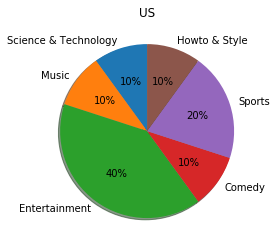

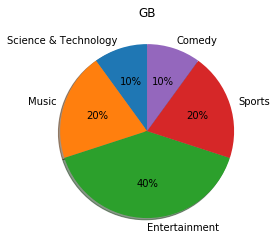

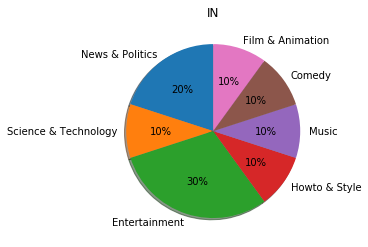

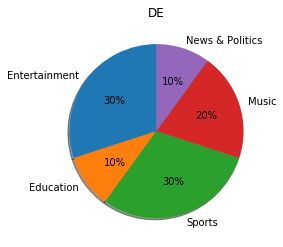

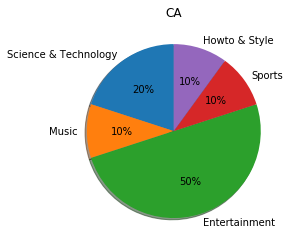

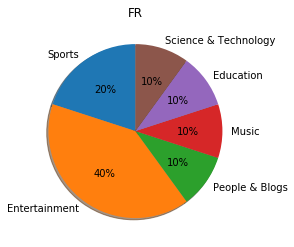

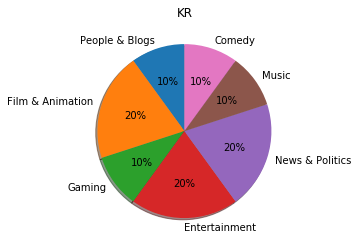

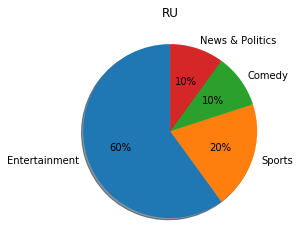

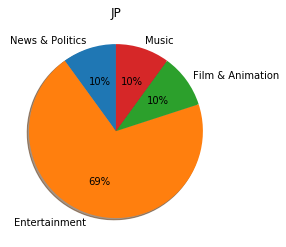

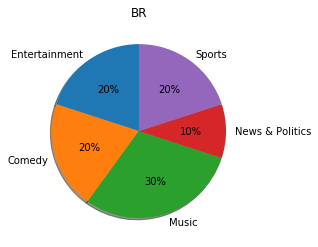

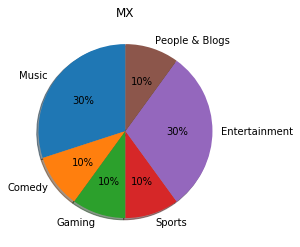

In [0]:
import pandas as pd
import matplotlib.pyplot as plt

# 각각의 categoryId에 해당하는 category명들을 dictionary로 만들었다
category = {'2' : "Autos & Vehicles", '1' : "Film & Animation", '10' : "Music", 
       '15' : "Pets & Animals", '17' : "Sports", '18' : "Short Movies", '19' : "Travel & Events", 
       '20' : "Gaming", '21' : "Videoblogging", '22' : "People & Blogs", '23' : "Comedy", 
       '24' : "Entertainment", '25' : "News & Politics", '26' : "Howto & Style", '27' : "Education", 
       '28' : "Science & Technology", '29' : "Nonprofits & Activism", '30' : "Movies", '31' : "Anime/Animation", 
       '32' : "Action/Adventure", '33' : "Classics", '34' : "Comedy", '35' : "Documentary", '36' : "Drama", 
       '37' : "Family", '38' : "Foreign", '39' : "Horror", '40' : "Sci-Fi/Fantasy", '41' : "Thriller", 
       '42' : "Shorts", '43' : "Shows", '44' : "Trailers"}

# 나라별로 csv files를 열고 dataframe으로 추출 - 데이터 가공 작업
for country_code in country_codes:
    contents = []
    number = []
    data = pd.read_csv(f"output/{time.strftime('%y.%d.%m')}_{country_code}_videos.csv", sep=',', dtype="unicode", encoding="utf-8")
    data = data.sort_values(by="view_count", ascending=False)
    data = data.iloc[:10]
    data = data.loc[:, ["categoryId"]]
    
    for i in range(10):
        dummy = category[data.iloc[i, 0]]
        if(contents.count(dummy) == 0):
            contents.append(dummy)
    for j in range(len(contents)):
        count = 0
        for i in range(10):
            dummy = category[data.iloc[i, 0]]
            if dummy == contents[j]:
                count = count + 1
        number.append(count)
    
    # matplot library의 pie를 통한 원형차트화
    plt.title(country_code)
    plt.pie(number,
           labels = contents,
           startangle = 90,
           shadow = True,
           autopct = "%1d%%")
    plt.show()

## 5. 분석 결과 도출
첫 번째 코드부분 실행 후 바로 위의 두 번째 코드부분을 실행하면 나라별로 원형차트들이 나온다. 위에서부터 미국, 영국, 인도, 독일, 캐나다, 프랑스, 한국, 러시아, 일본, 브라질, 멕시코 순서이다. 미국은 엔터테인먼트와 스포츠가 주를 이루고, 영국은 엔터테인먼트, 스포츠와 음악은 20%로 비슷했다. 인도는 엔터테인먼트와 뉴스 및 정치가 주를 이룬다. 독일은 엔터테인먼트와 스포츠가 30%로 똑같은 비율로 인기가 있고 그 바로 다음 20%가 음악이다. 캐나다는 절반이나 엔터테인먼트가 차지하고 있고 그 다음으로는 과학 및 기술 부분이 인기가 있다.프랑스는 엔터테인먼트가 40% 그 다음으로 20%가 스포츠였다.한국은 되게 골고루 존재했는데 엔터테인먼트, 뉴스 및 정치, 영화나 애니메이션이 20%로 골고루 인기가 있었다. 러시아는 엔터테인먼트가 60%나 되었는데 그 다음 20%가 스포츠분야였다.일본은 엔터테인먼트가 70%정도로 거의 카테고리의 주를 이루었다. 브라질은 우리나라보다도 훨씬 고르게 분포했는데, 음악이 30%로 제일 많았지만 엔터테인먼트, 코미디, 스포츠가 20%로 비슷비슷했다. 마지막으로 멕시코는 엔터테인먼트와 음악이 30%로 비슷하게 제일 인기가 많았다.

## 6. 결론
나라별로 엔터테인먼트가 대부분 첫번째로 인기가 많았지만, 대부분 30%이며 그 다음으로 인기가 있는 카테고리들은 서로 상이한 것으로 파악된다.

## 7. 참고문헌  
http://m.etnews.com/20170830000008  
https://www.nocutnews.co.kr/news/4971343  
https://m.blog.naver.com/PostView.nhn?blogId=doublet7411&logNo=221514043955&proxyReferer=https%3A%2F%2Fwww.google.com%2F  
https://www.kaggle.com/datasnaek/youtube-new#KRvideos.csv  
https://developers.google.com/youtube/v3/docs/search/list?hl=ko  
https://github.com/mitchelljy/Trending-YouTube-Scraper
